In [1]:
from glob import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm

from astropy.io import fits
import fitsio

In [2]:
import lightkurve as lk
from scipy import stats
from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.visualization import simple_norm

In [3]:
from roman_lcs import Machine, RomanMachine
from roman_lcs.utils import solve_linear_model

In [139]:
PATH = "/Users/jimartin/Work/ROMAN/TRExS/simulations/dryrun_01"
PATH = "/Volumes/seagate_exhd/trexs/DryRun_01"

In [140]:
FILTER = "F146"
FIELD = 3

ff = sorted(glob(f"{PATH}/simulated_image_data/rimtimsim_WFI_lvl02_{FILTER}_SCA02_field{FIELD:02}_rampfitted_exposureno_*_sim.fits"))
len(ff)

6595

In [133]:
ff[:3]

['/Users/jimartin/Work/ROMAN/TRExS/simulations/dryrun_01/simulated_image_data/F146/rimtimsim_WFI_lvl02_F146_SCA02_field03_rampfitted_exposureno_000000003_sim.fits',
 '/Users/jimartin/Work/ROMAN/TRExS/simulations/dryrun_01/simulated_image_data/F146/rimtimsim_WFI_lvl02_F146_SCA02_field03_rampfitted_exposureno_000000011_sim.fits',
 '/Users/jimartin/Work/ROMAN/TRExS/simulations/dryrun_01/simulated_image_data/F146/rimtimsim_WFI_lvl02_F146_SCA02_field03_rampfitted_exposureno_000000019_sim.fits']

In [134]:
catalog = pd.read_csv(f"{PATH}/metadata/TRExS_dryrun_01_MASTER_input_catalog_v1.1.txt", index_col=0)
catalog["flux"] = 10 ** ((27.53861667037689 - catalog["F146"])/2.5)
catalog["flux_err"] = np.sqrt(catalog["flux"])
catalog

RA_DEG    DEC_DEG    MEAN_XCOL    MEAN_YCOL     F062     F087  \
sicbro_id                                                                      
0          268.459367 -29.204578  1095.376132  1482.126518  15.4392  14.7968   
1          268.423498 -29.214936   369.577449   638.540030  16.2812  15.5638   
2          268.479460 -29.144276   608.397960  3559.902540  22.0708  20.4822   
3          268.521918 -29.283395  3949.616070    98.718337  13.3396  13.0864   
4          268.438270 -29.236865  1098.259143   214.568432  23.9187  22.0709   
...               ...        ...          ...          ...      ...      ...   
4973183    268.557144 -29.236327  4058.140767  2013.424249  20.0461  19.2765   
4973184    268.491378 -29.231094  2329.716787  1181.524921  20.2637  19.5704   
4973185    268.455785 -29.159407   264.928339  2758.686755  19.3494  18.5453   
4973186    268.578057 -29.178072  3626.688855  4043.484295  17.4934  16.6790   
4973187    268.505412 -29.203796  2232.736270  2196.179813  20.5581  19.7664   

              F106     F129     F158     F184  ...     F146  transitHost  \
sicbro_id                                      ...                         
0          14.4812  14.1656  14.0139  14.1573  ...  14.1319            0   
1          15.2477  14.9315  14.8541  14.9712  ...  14.9319            0   
2          19.7850  19.0877  18.9632  19.0253  ...  19.0378            1   
3          12.9245  12.7626  12.6962  12.8740  ...  12.7939            0   
4          21.0726  20.0742  19.9645  20.0445  ...  20.0404            1   
...            ...      ...      ...      ...  ...      ...          ...   
4973183    19.0026  18.7286  18.5340  18.6547  ...  18.6601            0   
4973184    19.3663  19.1623  19.0564  19.1856  ...  19.1505            0   
4973185    18.2062  17.8672  17.6650  17.7799  ...  17.7918            0   
4973186    16.3779  16.0768  15.8127  15.9289  ...  15.9648            0   
4973187    19.4655  19.1645  18.9804  19.0974  ...  19.1009            0   

           dimEB  blendedEB  lowmassEB  lowRedNoise  hiRedNoise  variable  \
sicbro_id                                                                   
0              0          0          0            1           0         1   
1              0          0          0            0           0         0   
2              0          0          0            0           1         1   
3              0          0          0            0           0         0   
4              0          0          0            0           0         1   
...          ...        ...        ...          ...         ...       ...   
4973183        0          0          0            0           0         0   
4973184        0          0          0            0           0         0   
4973185        0          0          0            0           0         0   
4973186        0          0          0            0           0         0   
4973187        0          0          0            0           0         0   

                    flux    flux_err  
sicbro_id                             
0          230508.353255  480.112855  
1          110328.234400  332.156942  
2            2513.776536   50.137576  
3          790472.322408  889.085104  
4             998.358841   31.596817  
...                  ...         ...  
4973183      3559.644834   59.662759  
4973184      2265.930933   47.601795  
4973185      7920.027110   88.994534  
4973186     42611.484865  206.425495  
4973187      2371.846986   48.701612  

[4973188 rows x 21 columns]

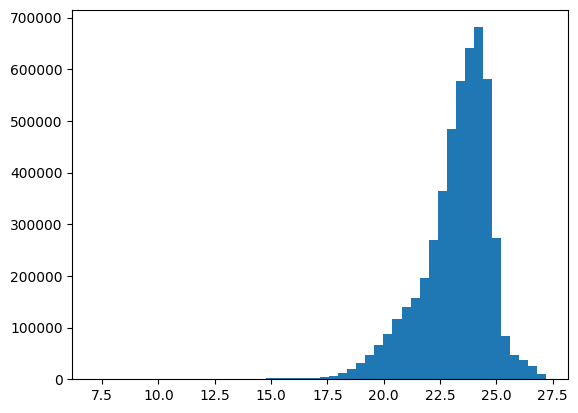

In [8]:
plt.hist(catalog.F146, bins=50)
plt.show()

# PSFMachine

## Build PRF mdoel with full data and $mag < 21$

In [49]:
cutout_size = 256
cutout_origin = (0, 512) # row, col

sources = catalog.query(
    f"F146 <= {21} and "
    f"MEAN_XCOL >= {cutout_origin[0]} and MEAN_XCOL <= {cutout_origin[0] + cutout_size} and "
    f"MEAN_YCOL >= {cutout_origin[1]} and MEAN_YCOL <= {cutout_origin[1] + cutout_size}"
).reset_index(drop=False)
sources = sources.rename(columns={"RA_DEG": "ra", "DEC_DEG": "dec", "MEAN_XCOL": "column", "MEAN_YCOL": "row"})
sources

sicbro_id          ra        dec      column         row     F062  \
0          1237  268.415295 -29.209779   80.111457  667.180304  19.4508   
1          1825  268.414133 -29.208721   33.716131  680.855799  19.3742   
2          2070  268.415388 -29.206511   28.789726  764.777514  15.7550   
3          2071  268.421638 -29.210011  242.309114  755.613241  19.0638   
4          2238  268.415733 -29.207703   56.981330  734.866781  23.3278   
...         ...         ...        ...         ...         ...      ...   
1812    4970551  268.416534 -29.215261  201.024315  524.345771  19.7646   
1813    4971020  268.412510 -29.210107   15.956445  615.688141  18.8878   
1814    4971076  268.418112 -29.209994  153.980151  703.135256  17.8644   
1815    4971756  268.412757 -29.211052   37.639660  591.557926  19.9707   
1816    4972857  268.415478 -29.207766   51.620173  729.187218  18.9061   

         F087     F106     F129     F158  ...     F146  transitHost  dimEB  \
0     18.6980  18.4092  18.1204  17.9006  ...  18.0456            0      0   
1     18.6858  18.4295  18.1732  17.9544  ...  18.1006            1      0   
2     15.5191  15.4993  15.4795  15.6112  ...  15.6325            0      0   
3     18.3726  18.0989  17.8252  17.6092  ...  17.7534            0      0   
4     21.9220  21.3371  20.7521  20.5693  ...  20.6763            1      0   
...       ...      ...      ...      ...  ...      ...          ...    ...   
1812  19.0350  18.8050  18.5750  18.4386  ...  18.5431            0      0   
1813  18.1992  17.9075  17.6159  17.4341  ...  17.5584            0      0   
1814  17.0614  16.7045  16.3476  16.1430  ...  16.2707            0      0   
1815  19.1152  18.8042  18.4933  18.2757  ...  18.4059            0      0   
1816  18.1534  17.8715  17.5895  17.3755  ...  17.5094            0      0   

      blendedEB  lowmassEB  lowRedNoise  hiRedNoise  variable          flux  \
0             0          0            0           0         0   6269.121230   
1             0          0            0           1         1   5959.456693   
2             0          0            0           0         0  57869.092009   
3             0          0            0           0         0   8205.152707   
4             0          0            0           1         1    555.810399   
...         ...        ...          ...         ...       ...           ...   
1812          0          0            0           0         0   3964.666564   
1813          0          0            0           0         0   9819.438810   
1814          0          0            0           0         0  32148.940741   
1815          0          0            0           0         0   4498.696223   
1816          0          0            0           0         0  10272.748794   

        flux_err  
0      79.177782  
1      77.197517  
2     240.559955  
3      90.582298  
4      23.575631  
...          ...  
1812   62.965598  
1813   99.093082  
1814  179.301257  
1815   67.072321  
1816  101.354570  

[1817 rows x 22 columns]

In [50]:
mac = RomanMachine.from_file(
    ff[:1], 
    sources=sources,
    sparse_dist_lim=2, 
    sources_flux_column="flux",
    cutout_size=cutout_size,
    cutout_origin=cutout_origin,
)
mac.contaminant_flux_limit = 10 ** ((27.648 - 21)/2.5)
mac

Creating delta arrays: 100%|██████████████████████████████████████████████████████████| 1817/1817 [00:00<00:00, 2224.85it/s]


RomanMachine (N sources, N times, N pixels): (1817, 1, 65536)

In [51]:
mac.image_shape

(256, 256)

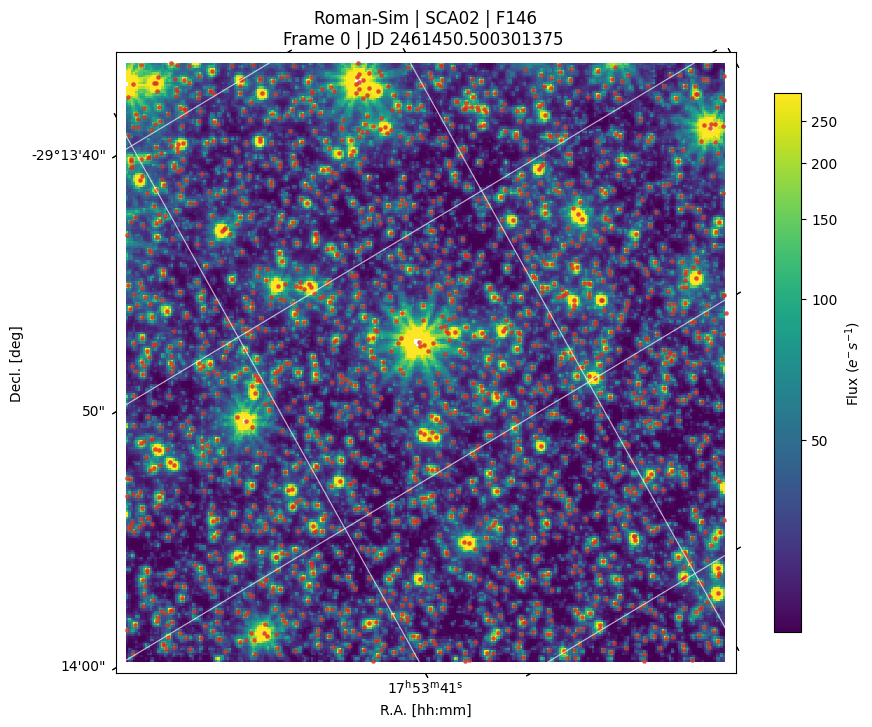

In [52]:
mac.plot_image(sources=True, frame_index=0);

In [53]:
examples = np.random.choice(mac.sources.query("F146 < 21").index.values, size=7*7, replace=False)
examples

array([ 226,  571,  707, 1202,  619, 1007,  954, 1767, 1384,  382, 1652,
       1647, 1374, 1360, 1813, 1358, 1408, 1456, 1505, 1660, 1513,  784,
        752,  606, 1159, 1066,  689,  364,  783,  187,  486,  950, 1559,
        570, 1645, 1725,  567, 1141,  142,  858, 1757, 1191, 1665,  994,
         76,  546, 1644, 1737, 1507])

Creating delta arrays: 100%|██████████████████████████████████████████████████████████| 1817/1817 [00:00<00:00, 2264.55it/s]
/Users/jimartin/miniforge3/envs/roman/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1562: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


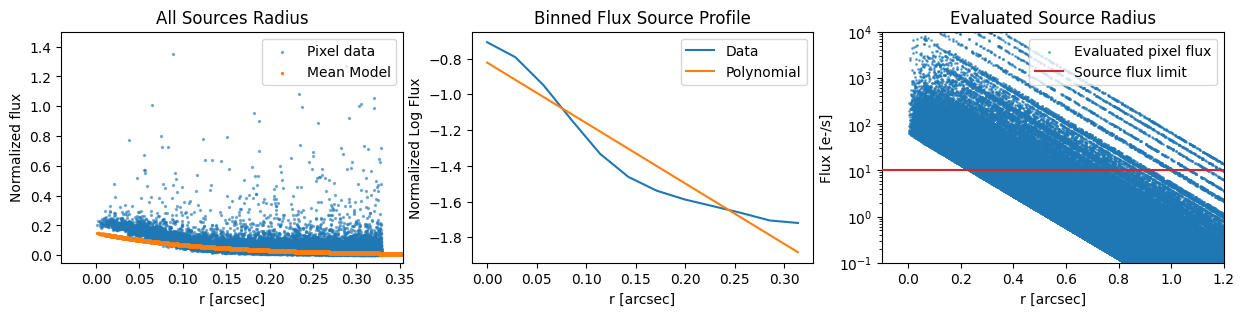

In [54]:
mac._get_source_mask(source_flux_limit=10, plot=True, reference_frame=0, iterations=1);

In [55]:
mac.r.data

array([2.7096669 , 2.73124611, 2.56098269, ..., 2.59887858, 2.75352425,
       2.73285034])

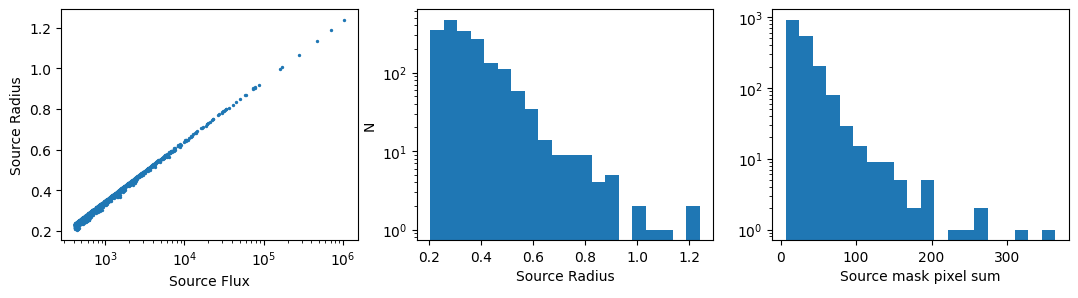

In [56]:
fig, ax = plt.subplots(1, 3, figsize=(13, 3))

ax[0].scatter(mac.sources.flux, mac.radius, s=2)
ax[0].set_xlabel("Source Flux")
ax[0].set_ylabel("Source Radius")
ax[0].set_xscale("log")

ax[1].hist(mac.radius, bins=20)
ax[1].set_xlabel("Source Radius")
ax[1].set_ylabel("N")
ax[1].set_yscale("log")

ax[2].hist(np.array(mac.source_mask.sum(axis=1)).ravel(), bins=20)
ax[2].set_xlabel("Source mask pixel sum")
ax[2].set_yscale("log")

plt.show()

In [57]:
from scipy import sparse

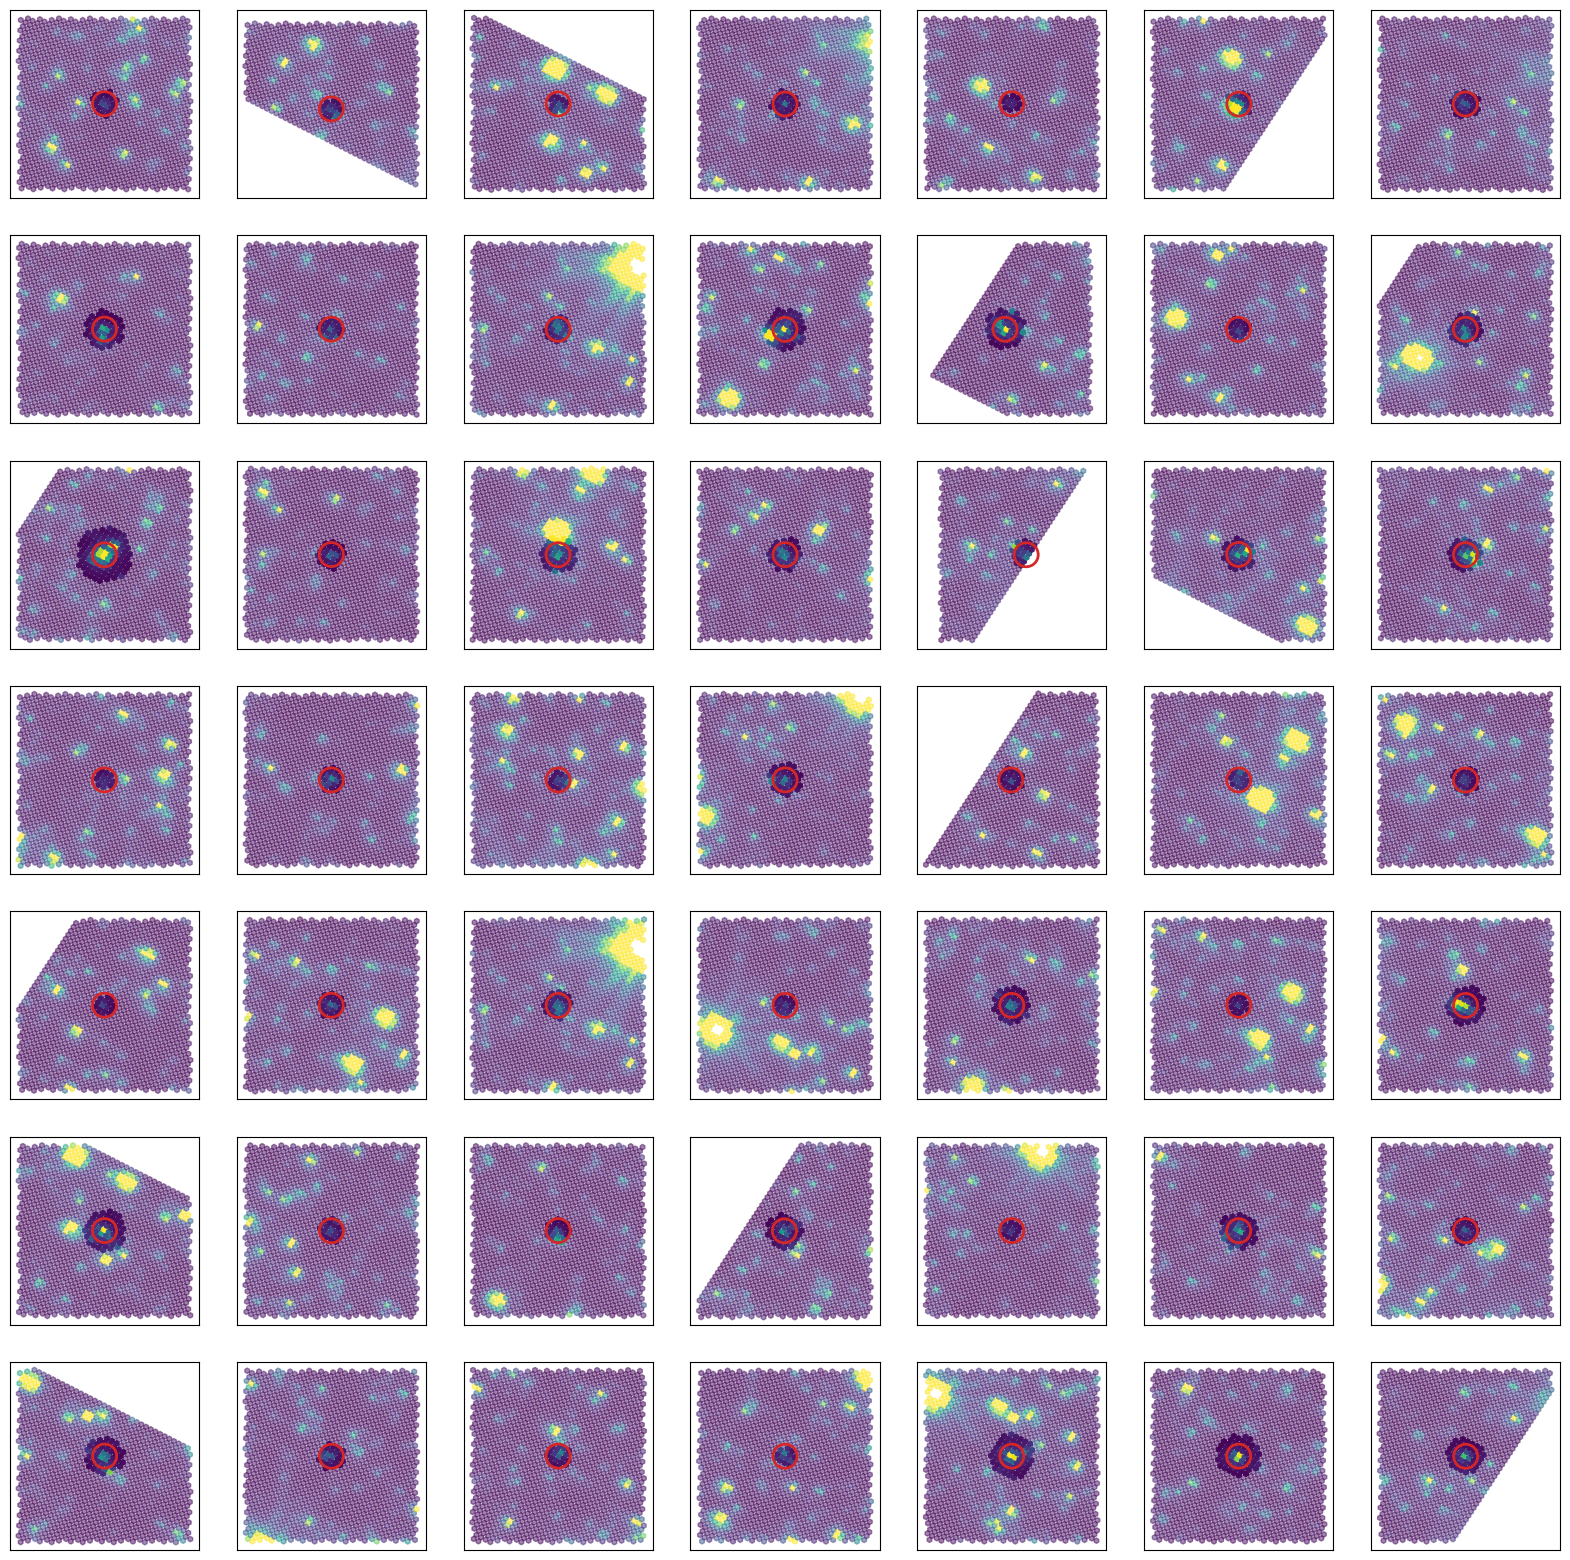

In [58]:
if sparse.issparse(mac.r):
    flux_masked = mac.r.astype(bool).multiply(mac.flux[0]).tocsr()
else:
    flux_masked = sparse.csr_matrix(mac.r.value.astype(bool) * mac.flux[0])

source_mask_dx = mac.source_mask.multiply(mac.dra).tocsr()
source_mask_dy = mac.source_mask.multiply(mac.ddec).tocsr()
source_mask_flux = mac.source_mask.multiply(mac.flux[0]).tocsr()

fig, ax = plt.subplots(7, 7, figsize=(20,20))

for i, k in enumerate(examples):
    if sparse.issparse(mac.r):
        xxx = mac.dra[k].data * 3600
        yyy = mac.ddec[k].data * 3600
    else:
        xxx = mac.dra[k].value * 3600
        yyy = mac.ddec[k].value * 3600
    ax.ravel()[i].scatter(xxx, 
                          yyy, 
                          s=15, marker="h", 
                          c=flux_masked[k].data, 
                          alpha=0.5,
                          vmin=10, vmax=500)
    ax.ravel()[i].scatter(source_mask_dx[k].data * 3600, 
                          source_mask_dy[k].data * 3600, 
                          s=15, marker="h", 
                          c=source_mask_flux[k].data, 
                          alpha=1,
                          vmin=10, vmax=500)
    ax.ravel()[i].scatter(0, 0, s=300, edgecolor="tab:red", marker="o", facecolor="none", lw=2)
    ax.ravel()[i].axis('equal')
    ax.ravel()[i].set_xticks([])
    ax.ravel()[i].set_yticks([])
    if not sparse.issparse(mac.r):
        ax.ravel()[i].set_xlim(-2, 2)
        ax.ravel()[i].set_ylim(-2, 2)
plt.show()

In [59]:
mac.source_mask, mac.uncontaminated_source_mask

(<Compressed Sparse Row sparse matrix of dtype 'bool'
 	with 59096 stored elements and shape (1817, 65536)>,
 <Compressed Sparse Row sparse matrix of dtype 'bool'
 	with 23811 stored elements and shape (1817, 65536)>)

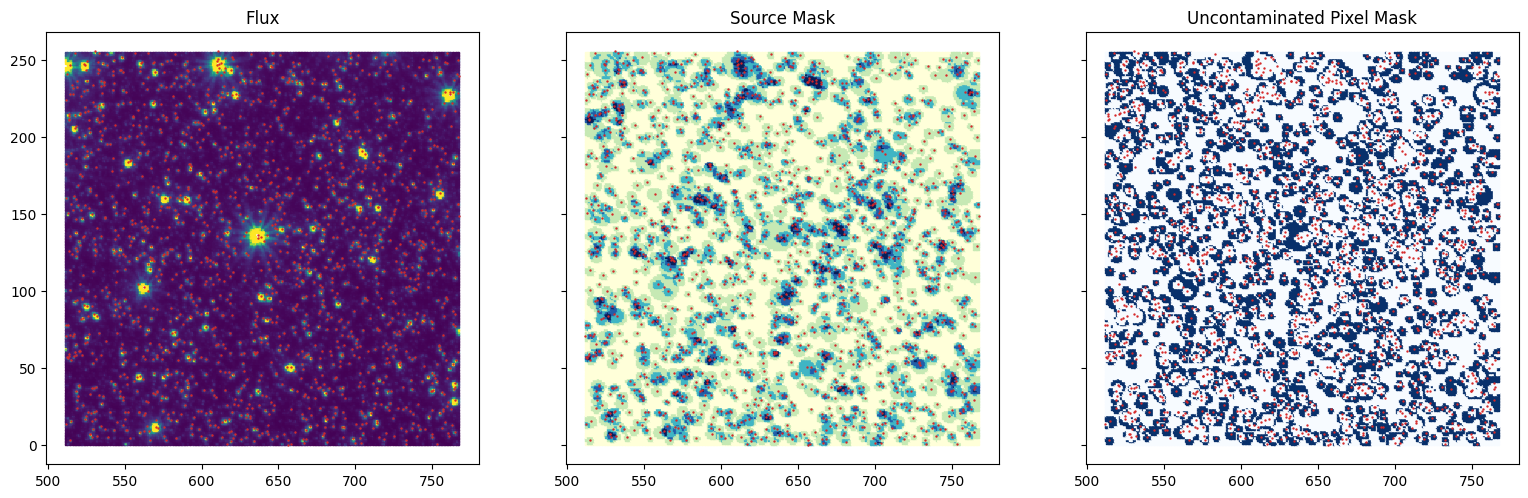

In [61]:
# mac._update_source_mask(frame_index=mac.ref_frame)
ROW, COL = mac.pixel_coordinates(mac.ref_frame)
if cutout_size > 200:
    pixs = 1
else:
    pixs = 10

fig, ax = plt.subplots(1, 3, figsize=(19, 9), sharex=True, sharey=True)

ax[0].set_title("Flux")
ax[0].scatter(
    mac.column,
    mac.row,
    c=mac.flux[mac.ref_frame], 
    vmin=10, 
    vmax=500,
    s=pixs,
    marker="s",
)
ax[0].scatter(COL, ROW, c="tab:red", marker=".", s=2)

ax[1].set_title("Source Mask")
ax[1].scatter(
    mac.column,
    mac.row,
    c=np.array(mac.source_mask.sum(axis=0)[0]), 
    vmin=0, 
    vmax=4,
    alpha=1,
    cmap="YlGnBu",
    s=pixs,
    marker="s",
)
ax[1].scatter(COL, ROW, c="tab:red", marker=".", s=2)

ax[2].set_title("Uncontaminated Pixel Mask")
ax[2].scatter(
    mac.column,
    mac.row,
    c=np.array(mac.uncontaminated_source_mask.sum(axis=0)[0]), 
    vmin=0, 
    vmax=1,
    alpha=1,
    cmap="Blues",
    s=pixs,
    marker="s",
)
ax[2].scatter(COL, ROW, c="tab:red", marker=".", s=2)

ax[0].set_aspect("equal", adjustable="box")
ax[1].set_aspect("equal", adjustable="box")
ax[2].set_aspect("equal", adjustable="box")

plt.show()

Creating delta arrays: 100%|██████████████████████████████████████████████████████████| 1807/1807 [00:00<00:00, 2244.03it/s]
/Users/jimartin/miniforge3/envs/roman/lib/python3.10/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


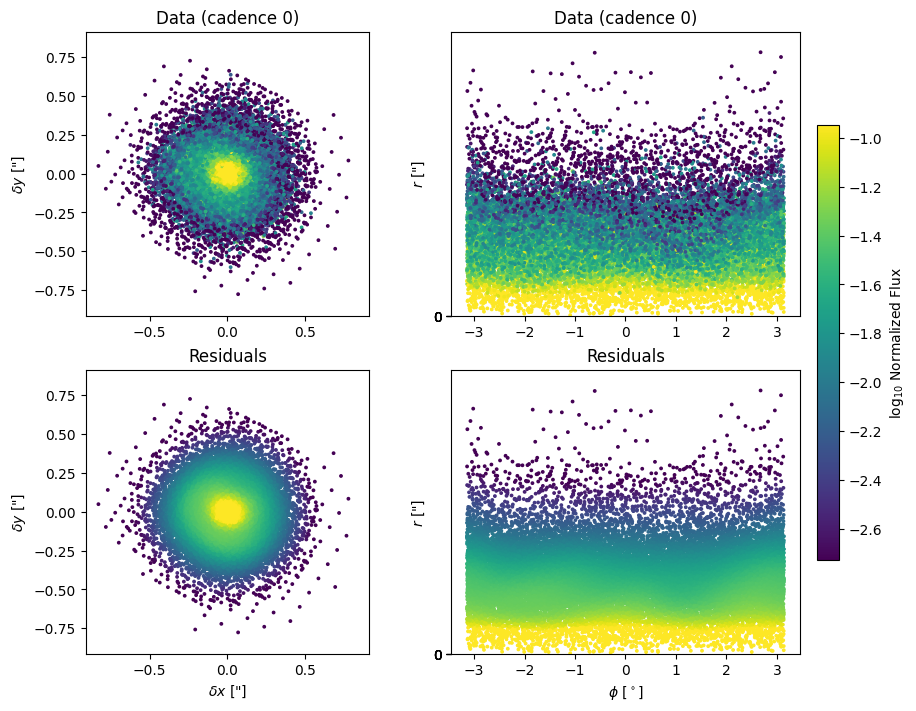

In [23]:
mac.rmin = 0.02
mac.rmax = 0.8
mac.cut_r = 0.2
mac.n_r_knots = 9
mac.n_phi_knots = 9
psf_tdx = 0

mac.build_shape_model(
    plot=True,
    flux_cut_off=0.2,
    frame_index=psf_tdx,
    bin_data=False,
)
plt.show()

In [24]:
output = f"./data/roman_WFI_{mac.meta['READMODE']}_{mac.meta['FILTER']}_{mac.meta['DETECTOR']}_shape_model_cad{psf_tdx}.fits"
# mac.save_shape_model(output=output)

In [31]:
mac.quiet = True
mac.fit_model()

Fitting 1807 Sources (w. VA):   0%|                                                                   | 0/1 [00:00<?, ?it/s]/Users/jimartin/miniforge3/envs/roman/lib/python3.10/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
Fitting 1807 Sources (w. VA): 100%|███████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.77s/it]

In [32]:
mac.ws

array([[nan, nan, nan, ..., nan, nan, nan]])

In [27]:
mac.source_mask.multiply(mac.dra)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 51290 stored elements and shape (1807, 65536)>

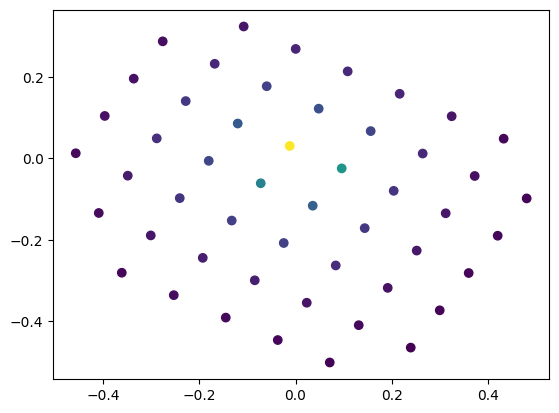

In [138]:
idx = 50


plot_x = mac.source_mask.multiply(mac.dra).tocsr()[idx].data * 3600
plot_y = mac.source_mask.multiply(mac.ddec).tocsr()[idx].data * 3600
plot_mm = mac.mean_model[idx].data

plt.scatter(plot_x, plot_y, c=plot_mm);

In [269]:
idx = 0
fdx = 10

pmu = np.atleast_1d(mac.sources.flux[idx:fdx])
psigma = np.atleast_1d(5 * (np.abs(mac.sources.flux[idx:fdx]) ** 0.5))

new_mm = (mac.mean_model / mac.mean_model.sum(axis=1)).tocsr()

phot, phot_err = solve_linear_model(
    new_mm[idx:fdx].T.copy(),
    mac.flux[0],
    y_err=mac.flux_err[0],
    prior_mu=pmu,
    prior_sigma=psigma,
    errors=True,
)
phot, phot_err, pmu

(array([11139.37747504,  1265.66004582,  4832.89452153,  2483.33748287,
         1728.03947004, 13361.14355618,  2661.95839018, 10001.81408215,
         3058.82987743,   824.4472646 ]),
 array([15.47705492,  5.11205136,  9.83134363,  7.13575791,  5.97699491,
        17.43530681,  7.31517978, 14.63987104,  7.80465739,  4.15173858]),
 array([17891.49651372,   811.49653196,  6342.29835291,  1853.90155256,
         1645.60905402, 25156.29437609,  2207.83527644,  1795.58789177,
         1351.09743082,   616.77486678]))

In [110]:
mac.mean_model[11].data

array([0.00576854, 0.0059844 , 0.00469196, 0.00605738, 0.00883303,
       0.01044685, 0.01161384, 0.0097328 , 0.00494543, 0.01077371,
       0.01714142, 0.02572368, 0.02228523, 0.01739422, 0.00961407,
       0.00352242, 0.00905425, 0.01767616, 0.02969419, 0.0333224 ,
       0.0385671 , 0.03001492, 0.01857997, 0.00739516, 0.011363  ,
       0.02162798, 0.04038103, 0.1034132 , 0.16575425, 0.03519695,
       0.01959995, 0.01128255, 0.01023584, 0.02811399, 0.03626895,
       0.10333893, 0.0782559 , 0.02921562, 0.02006709, 0.01124001,
       0.00823118, 0.01839683, 0.03018155, 0.03013034, 0.02344771,
       0.01791402, 0.01965945, 0.00965542, 0.01019036, 0.01095247,
       0.01568734, 0.01865863, 0.01884164, 0.01564372, 0.01301418,
       0.01350032, 0.00845521, 0.00704977, 0.0065051 , 0.00940266])

In [111]:
pmu, psigma

(array([190373.57614471,   3811.06773932,   3704.1338201 ,   4598.82271863,
           604.45874923,  13307.1995101 ,   1746.17058534,    640.74712787,
          2057.62708573,    570.48820298]),
 array([2181.59102575,  308.66922989,  304.30797805,  339.07310121,
         122.92871402,  576.78417779,  208.93603   ,  126.56491693,
         226.80537283,  119.42447435]))

In [112]:
new_mm[:idx].sum(axis=1)

matrix([], shape=(0, 1), dtype=float64)

In [270]:
mac.quiet = True
mac.fit_model()

 ... (more hidden) .../Users/jimartin/miniforge3/envs/roman/lib/python3.10/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
 ... (more hidden) ...


LinAlgError: Singular matrix

In [ ]:
mac.ws

In [115]:
np.nansum(mac.ws)

0.0

In [1]:
import lightkurve as lk

In [ ]:
lk.search_tesscut()

## Evaluate Model on substamp with full catalog

In [64]:
cutout_size = 32
cutout_origin = (0, 4062)
mag_limit = 23

sources = catalog.query(
    f"F146 <= {mag_limit} and "
    f"MEAN_XCOL >= {cutout_origin[0] - 1} and MEAN_XCOL <= {cutout_origin[0] + cutout_size + 1} and "
    f"MEAN_YCOL >= {cutout_origin[1] - 1} and MEAN_YCOL <= {cutout_origin[1] + cutout_size + 1}"
).reset_index(drop=False)
sources = sources.rename(columns={"RA_DEG": "ra", "DEC_DEG": "dec", "MEAN_XCOL": "column", "MEAN_YCOL": "row"})
sources

sicbro_id          ra        dec     column          row     F062  \
0       28611  268.470186 -29.122291  16.021744  4068.152756  21.8533   
1      184876  268.470720 -29.122147  27.009495  4080.426982  23.6851   
2      196153  268.469964 -29.121794   2.326061  4079.472551  24.9191   
3      244043  268.471045 -29.121966  32.190441  4090.629521  23.8568   
4      291388  268.470172 -29.121581   4.035279  4088.842691  24.7139   
..        ...         ...        ...        ...          ...      ...   
95    4860250  268.470302 -29.121600   7.590830  4090.245162  20.9013   
96    4916094  268.469944 -29.121981   4.888956  4073.653952  21.0624   
97    4920111  268.469865 -29.122171   6.056933  4066.857768  19.9671   
98    4941228  268.470303 -29.121865  11.981712  4082.463269  20.1660   
99    4944801  268.470520 -29.122055  20.515999  4080.113097  19.9991   

       F087     F106     F129     F158  ...     F146  transitHost  dimEB  \
0   20.8893  20.5541  20.2190  19.9177  ...  20.0863            1      0   
1   22.5784  22.1981  21.8178  21.4285  ...  21.6244            0      0   
2   23.5153  22.9731  22.4309  22.0690  ...  22.2435            0      0   
3   22.7655  22.3660  21.9664  21.6293  ...  21.8024            0      0   
4   23.5977  23.1780  22.7583  22.4908  ...  22.6278            0      0   
..      ...      ...      ...      ...  ...      ...          ...    ...   
95  20.2767  20.1086  19.9406  19.8803  ...  19.9595            0      0   
96  20.3758  20.2015  20.0273  19.9845  ...  20.0544            0      0   
97  19.3392  19.1897  19.0402  19.0403  ...  19.0964            0      0   
98  19.5755  19.4319  19.2884  19.2838  ...  19.3427            0      0   
99  19.3105  19.1403  18.9702  18.9377  ...  19.0034            0      0   

    blendedEB  lowmassEB  lowRedNoise  hiRedNoise  variable         flux  \
0           0          0            0           0         1   957.032460   
1           0          0            0           0         0   232.106161   
2           0          0            0           0         0   131.234091   
3           0          0            0           0         0   197.009273   
4           0          0            0           0         0    92.114218   
..        ...        ...          ...         ...       ...          ...   
95          0          0            0           0         0  1075.589783   
96          0          0            0           0         0   985.568168   
97          0          0            0           0         0  2381.697869   
98          0          0            0           0         0  1898.307957   
99          0          0            0           0         0  2594.697110   

     flux_err  
0   30.935941  
1   15.235031  
2   11.455745  
3   14.035999  
4    9.597615  
..        ...  
95  32.796185  
96  31.393760  
97  48.802642  
98  43.569576  
99  50.938169  

[100 rows x 22 columns]

In [65]:
mac = RomanMachine.from_file(
    ff, 
    sources=sources,
    sparse_dist_lim=2, 
    sources_flux_column="flux",
    cutout_size=cutout_size,
    cutout_origin=cutout_origin,
)
mac.contaminant_flux_limit = 10 ** ((27.648 - 21)/2.5)
mac

100%|████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 170.15it/s]


RomanMachine (N sources, N times, N pixels): (100, 121, 832)

In [66]:
mac.image_shape

(32, 26)

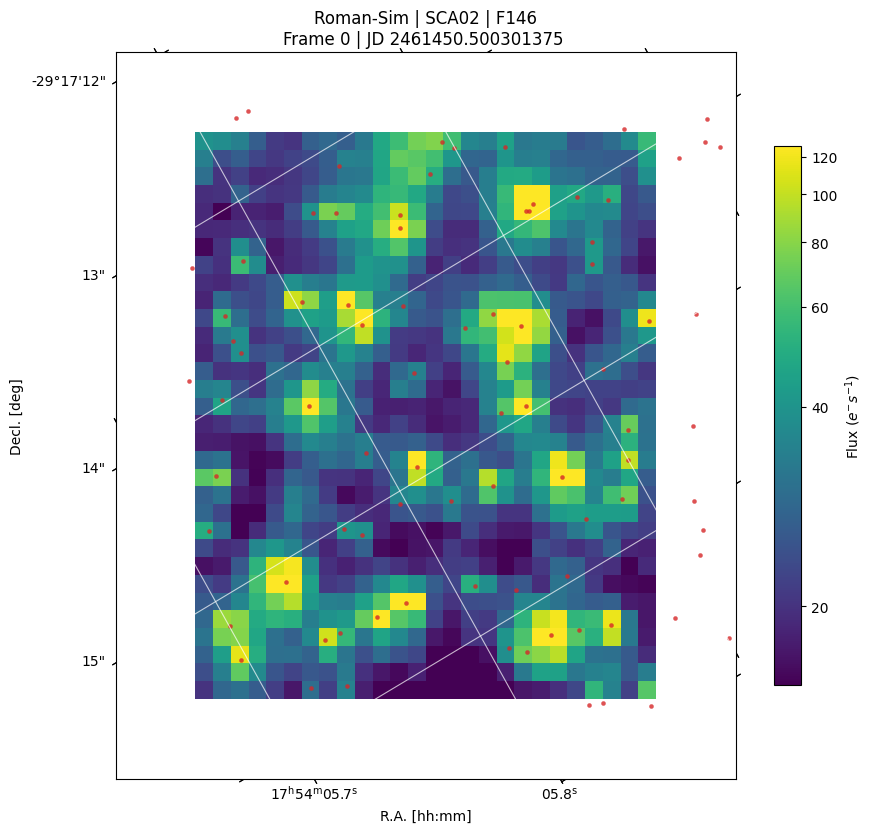

In [67]:
mac.plot_image(sources=True, frame_index=0);

In [68]:
mac.meta

{'MISSION': 'Roman-Sim',
 'TELESCOP': 'Roman',
 'SOFTWARE': 'rimtimsim_v2.0',
 'RADESYS': 'FK5',
 'EQUINOX': 2000.0,
 'FILTER': 'F146',
 'FIELD': 1,
 'DETECTOR': 'SCA02',
 'EXPOSURE': 54.72,
 'READMODE': 'ramp'}

/Users/jimartin/miniforge3/envs/roman/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1562: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/jimartin/miniforge3/envs/roman/lib/python3.10/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


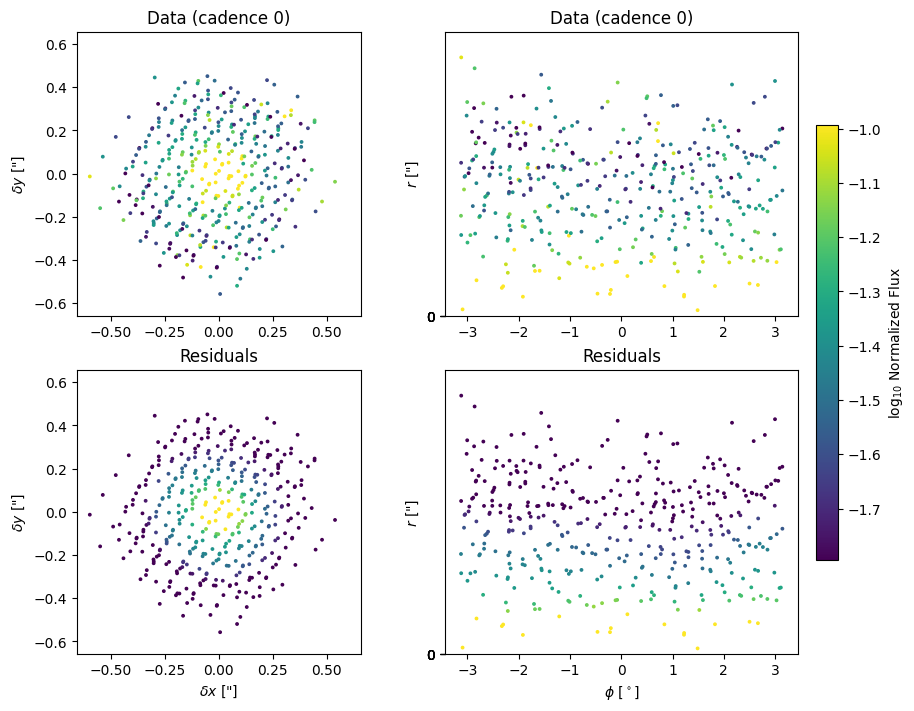

In [69]:
mac.load_shape_model(output, flux_cut_off=0.1, plot=True, source_flux_limit=10);

In [70]:
mac.sources

sicbro_id          ra        dec     column          row     F062  \
0       28611  268.470186 -29.122291  16.021744  4068.152756  21.8533   
1      184876  268.470720 -29.122147  27.009495  4080.426982  23.6851   
2      196153  268.469964 -29.121794   2.326061  4079.472551  24.9191   
3      244043  268.471045 -29.121966  32.190441  4090.629521  23.8568   
4      291388  268.470172 -29.121581   4.035279  4088.842691  24.7139   
..        ...         ...        ...        ...          ...      ...   
95    4860250  268.470302 -29.121600   7.590830  4090.245162  20.9013   
96    4916094  268.469944 -29.121981   4.888956  4073.653952  21.0624   
97    4920111  268.469865 -29.122171   6.056933  4066.857768  19.9671   
98    4941228  268.470303 -29.121865  11.981712  4082.463269  20.1660   
99    4944801  268.470520 -29.122055  20.515999  4080.113097  19.9991   

       F087     F106     F129     F158  ...     F146  transitHost  dimEB  \
0   20.8893  20.5541  20.2190  19.9177  ...  20.0863            1      0   
1   22.5784  22.1981  21.8178  21.4285  ...  21.6244            0      0   
2   23.5153  22.9731  22.4309  22.0690  ...  22.2435            0      0   
3   22.7655  22.3660  21.9664  21.6293  ...  21.8024            0      0   
4   23.5977  23.1780  22.7583  22.4908  ...  22.6278            0      0   
..      ...      ...      ...      ...  ...      ...          ...    ...   
95  20.2767  20.1086  19.9406  19.8803  ...  19.9595            0      0   
96  20.3758  20.2015  20.0273  19.9845  ...  20.0544            0      0   
97  19.3392  19.1897  19.0402  19.0403  ...  19.0964            0      0   
98  19.5755  19.4319  19.2884  19.2838  ...  19.3427            0      0   
99  19.3105  19.1403  18.9702  18.9377  ...  19.0034            0      0   

    blendedEB  lowmassEB  lowRedNoise  hiRedNoise  variable         flux  \
0           0          0            0           0         1   957.032460   
1           0          0            0           0         0   232.106161   
2           0          0            0           0         0   131.234091   
3           0          0            0           0         0   197.009273   
4           0          0            0           0         0    92.114218   
..        ...        ...          ...         ...       ...          ...   
95          0          0            0           0         0  1075.589783   
96          0          0            0           0         0   985.568168   
97          0          0            0           0         0  2381.697869   
98          0          0            0           0         0  1898.307957   
99          0          0            0           0         0  2594.697110   

     flux_err  
0   30.935941  
1   15.235031  
2   11.455745  
3   14.035999  
4    9.597615  
..        ...  
95  32.796185  
96  31.393760  
97  48.802642  
98  43.569576  
99  50.938169  

[100 rows x 22 columns]

In [71]:
mac.quiet = True

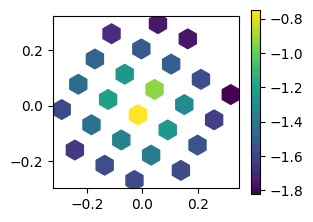

In [40]:
idx = 10

plot_x = mac.source_mask.multiply(mac.dra).tocsr()[idx].data * 3600
plot_y = mac.source_mask.multiply(mac.ddec).tocsr()[idx].data * 3600
plot_mm = mac.mean_model[idx].data

plt.figure(figsize=(3, 3))
bar = plt.scatter(plot_x, plot_y, c=np.log10(plot_mm), s=200, marker="h");
plt.colorbar(bar, shrink=0.8)
plt.gca().set_aspect('equal')


In [72]:
mac.fit_model()

Fitting 100 Sources (w. VA):   0%|                                                                  | 0/121 [00:00<?, ?it/s]/Users/jimartin/miniforge3/envs/roman/lib/python3.10/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
Fitting 100 Sources (w. VA): 100%|████████████████████████████████████████████████████████| 121/121 [00:03<00:00, 32.01it/s]


In [116]:
mac.get_psf_metrics(npoints_per_pixel=0)

In [75]:
mac.ws.shape

(121, 100)

In [74]:
import lightkurve as lk

In [85]:
mac.sources.columns

Index(['sicbro_id', 'ra', 'dec', 'column', 'row', 'F062', 'F087', 'F106',
       'F129', 'F158', 'F184', 'F213', 'F146', 'transitHost', 'dimEB',
       'blendedEB', 'lowmassEB', 'lowRedNoise', 'hiRedNoise', 'variable',
       'flux', 'flux_err'],
      dtype='object')

In [79]:
mac.sources["F146"]

0     20.0863
1     21.6244
2     22.2435
3     21.8024
4     22.6278
       ...   
95    19.9595
96    20.0544
97    19.0964
98    19.3427
99    19.0034
Name: F146, Length: 100, dtype: float64

In [120]:
DATPATH = f"/Users/jimartin/Work/ROMAN/TRExS/Roman-lcs/data"

In [122]:
for k in range(mac.nsources):
    meta = mac.meta.copy()
    meta["INSTRUME"] = "WFI"
    meta["SICBROID"] = f'{mac.sources["sicbro_id"].iloc[k]}'
    meta["RADESYS"] = "ICRS"
    meta["RA_OBJ"] = mac.sources["ra"].iloc[k]
    meta["DEC_OBJ"] = mac.sources["dec"].iloc[k]
    meta["F146_mag"] = mac.sources["F146"].iloc[k]
    meta["F146_flx"] = mac.sources["flux"].iloc[k]

    corr_flux = (mac.ws[:, k] / np.nanmedian(mac.ws[:, k])) * np.random.normal(mac.sources["flux"].iloc[k], mac.sources["flux_err"].iloc[k])
    
    lcf = lk.LightCurve(
                time=mac.time * u.d,
                flux=corr_flux * u.electron / u.second,
                flux_err=mac.werrs[:, k] * u.electron / u.second,
                meta=meta,
                time_format="jd",
            )
    fname = (f"{DATPATH}/lcs/roman_wfi_{meta['SICBROID']}_{meta['FILTER']}_dryrun01_lc.fits")
    lcf.to_fits(fname, overwrite=True, flux_column_name='FLUX', **meta)
    # break

/var/folders/9v/pf39l8vn4dv810cyn39k_xk05nh7q7/T/ipykernel_48625/3686252683.py:11: RuntimeWarning: All-NaN slice encountered
  corr_flux = (mac.ws[:, k] / np.nanmedian(mac.ws[:, k])) * np.random.normal(mac.sources["flux"].iloc[k], mac.sources["flux_err"].iloc[k])


In [112]:
lcf.meta

{'MISSION': 'Roman-Sim',
 'TELESCOP': 'Roman',
 'SOFTWARE': 'rimtimsim_v2.0',
 'RADESYS': 'ICRS',
 'EQUINOX': 2000.0,
 'FILTER': 'F146',
 'FIELD': 1,
 'DETECTOR': 'SCA02',
 'EXPOSURE': 54.72,
 'READMODE': 'ramp',
 'INSTRUME': 'WFI',
 'SICBROID': '28611',
 'RA_OBJ': 268.4701856192955,
 'DEC_OBJ': -29.12229086281093,
 'F146_mag': 20.0863,
 'F146_flx': 957.0324600184754,
 'TIME_FORMAT': 'jd'}

In [113]:
lcf.to_fits("./data/lc_test.fits", overwrite=True, flux_column_name='FLUX', **meta)

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x368ba71c0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x368ba6da0>]

<Axes: xlabel='Time [JD]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

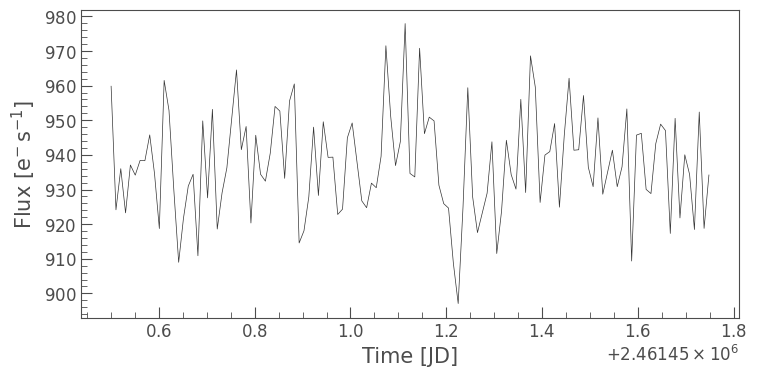

In [114]:
lcf.plot()

In [127]:
from astropy.table import Table

In [131]:
lc_test = Table.read("/Users/jimartin/Work/ROMAN/TRExS/Roman-lcs/data/lcs/roman_wfi_4610202_F146_dryrun01_lc.fits")
lc_test

<Table length=121>
       TIME            FLUX       FLUX_ERR   SAP_QUALITY
        jd         electron / s electron / s            
     float64         float32      float32       int32   
------------------ ------------ ------------ -----------
 2461450.500301375     787.0721    3.9104817           0
2461450.5104192654    785.51056    3.9676468           0
               ...          ...          ...         ...
 2461451.728170583     746.2134    3.9818745           0
 2461451.738244746    786.33685    3.8859668           0
2461451.7483499935     742.7205    3.9883792           0